Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition (10).csv


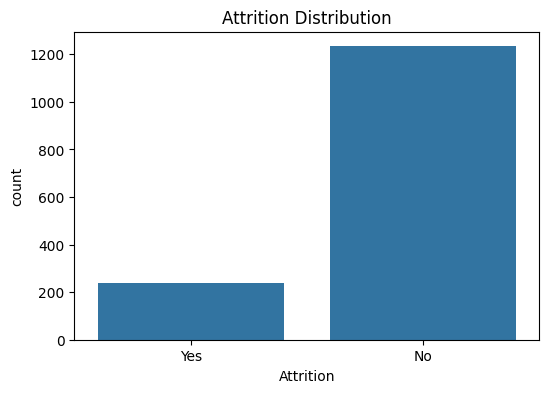

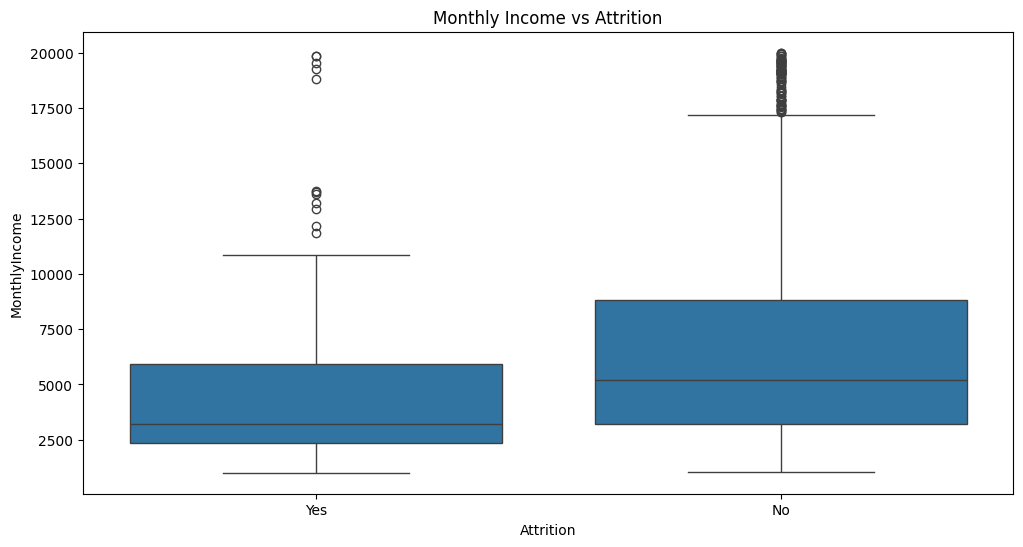

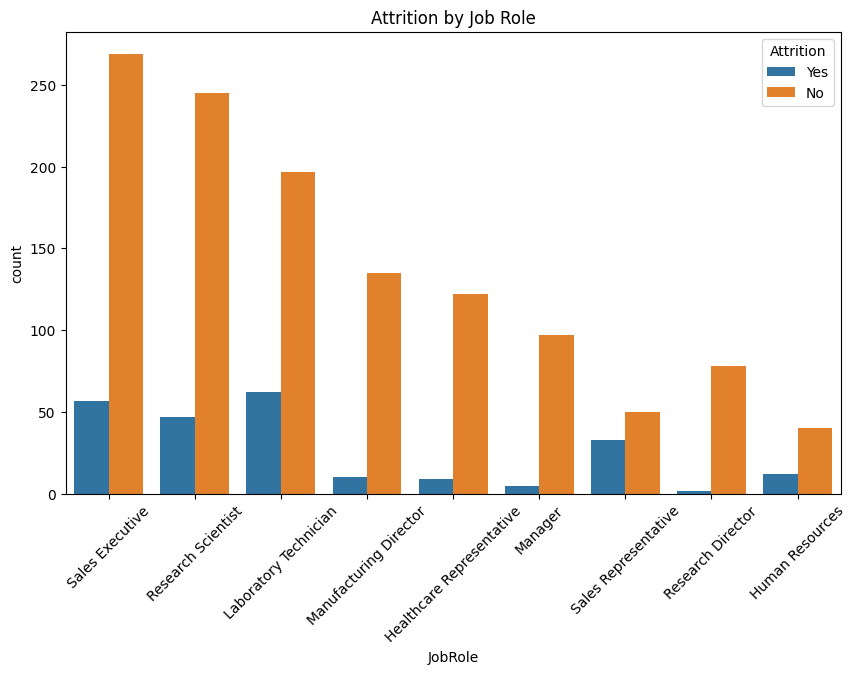

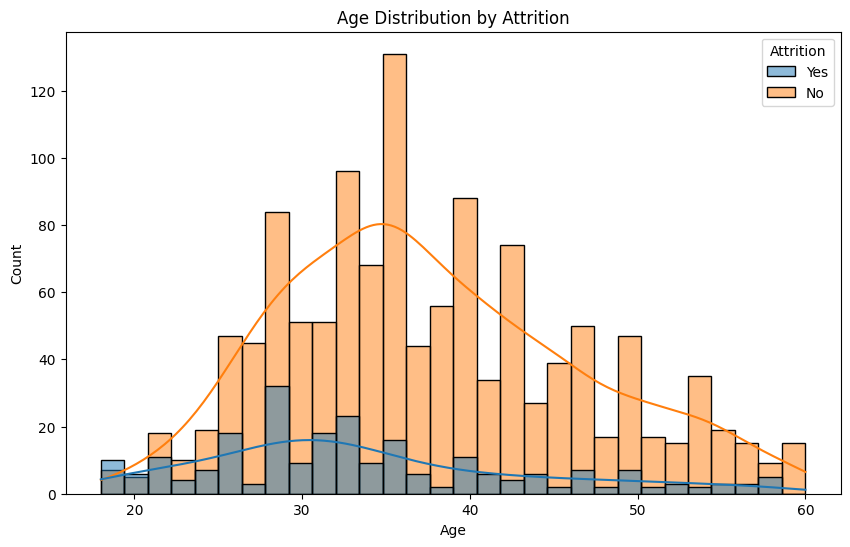

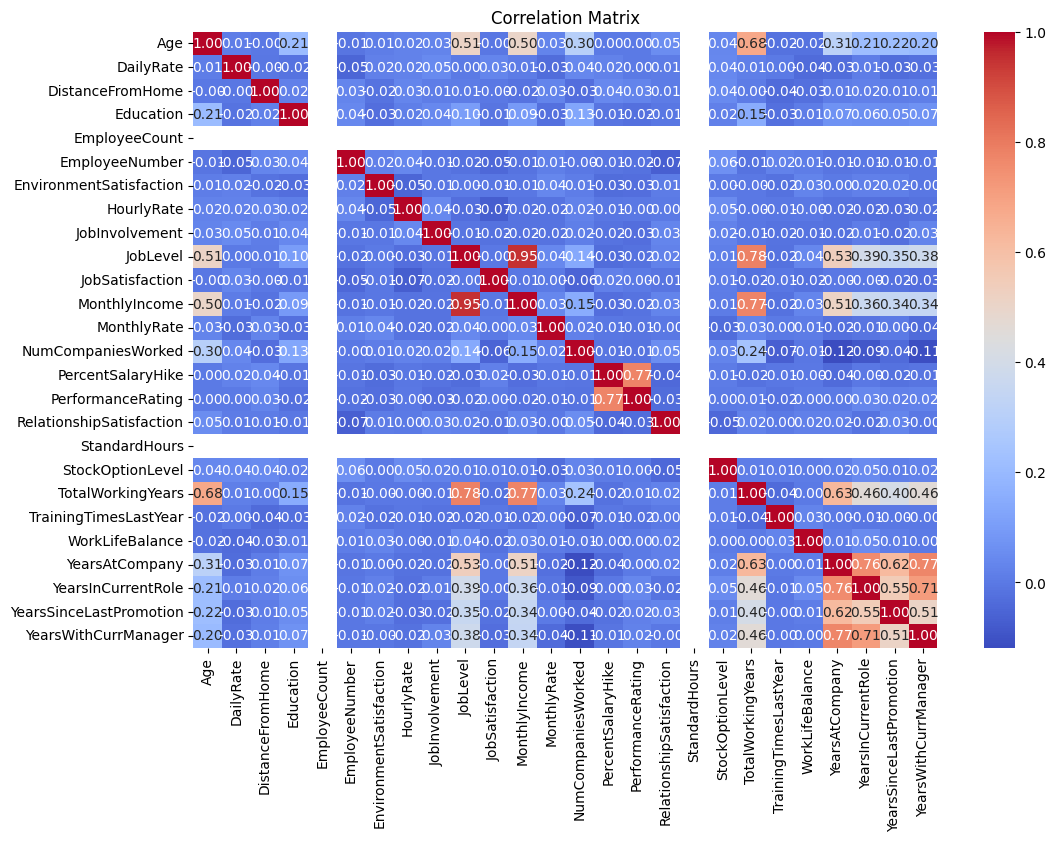

📊 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       247
           1       0.69      0.38      0.49        47

    accuracy                           0.87       294
   macro avg       0.79      0.68      0.71       294
weighted avg       0.86      0.87      0.86       294

🌲 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.38      0.11      0.17        47

    accuracy                           0.83       294
   macro avg       0.62      0.54      0.54       294
weighted avg       0.78      0.83      0.79       294



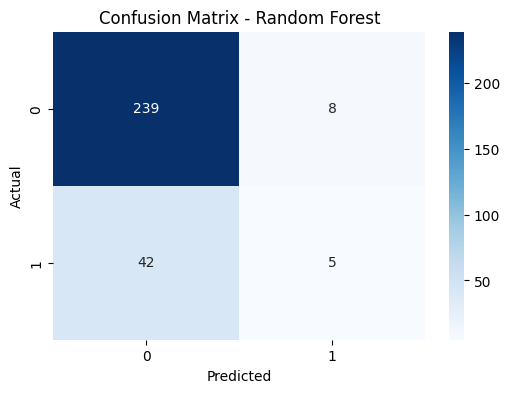

✅ SHAP values shape: (294, 34, 2)
✅ X_test shape: (294, 34)


<Figure size 640x480 with 0 Axes>

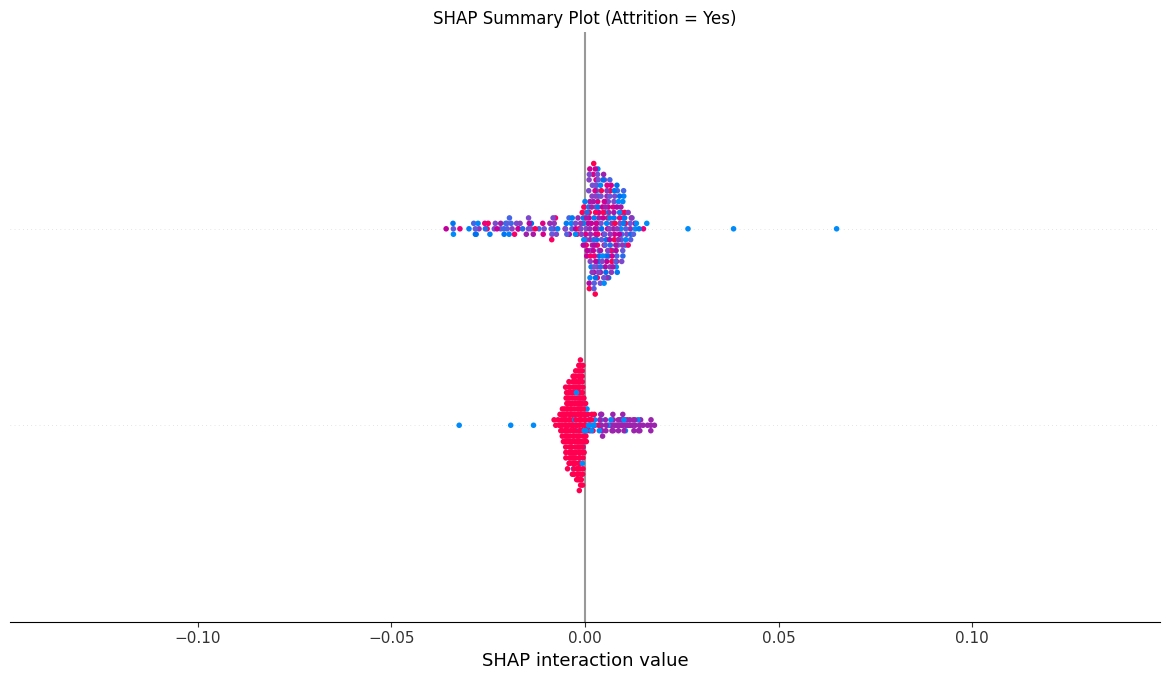


🔧 DEBUGGING INFO:
Original features count: 34
SHAP values shape: (68,)
First 5 feature names: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome']
First 5 SHAP values: [0.02184835 0.02184835 0.00419006 0.00419006 0.00946031]

⚠️ Warning: Feature count mismatch (34 features vs 68 SHAP values)
Possible causes:
- Some features were dropped during training (constant/non-informative)
- Categorical encoding created different feature counts

✅ Successfully created importance DataFrame!
                    feature  importance
1            BusinessTravel    0.021848
0                       Age    0.021848
26         StockOptionLevel    0.013761
27        TotalWorkingYears    0.013761
9   EnvironmentSatisfaction    0.012685


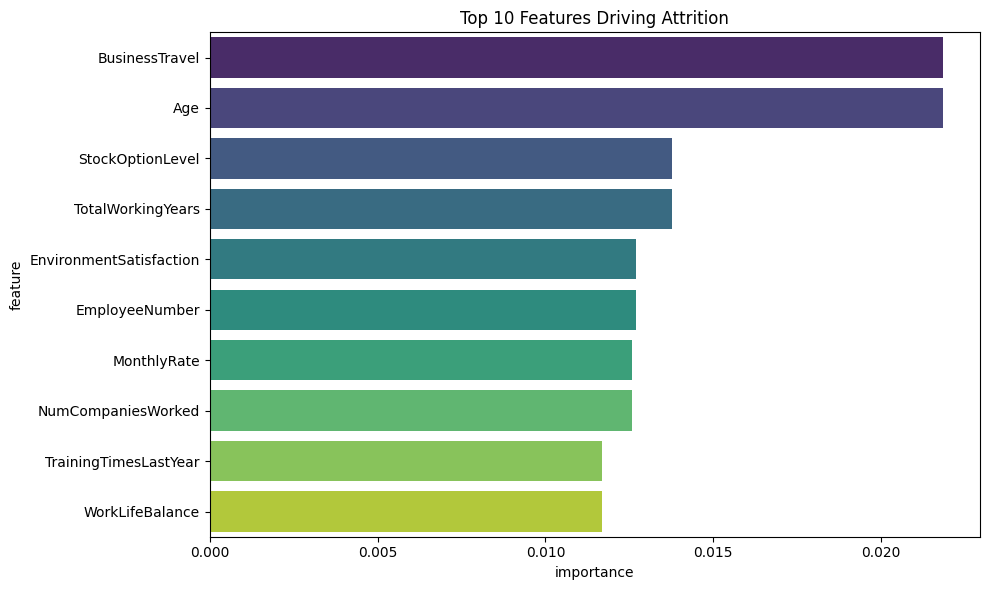


🔍 Key Drivers of Attrition:
2. BusinessTravel (Impact score: 0.0218)
1. Age (Impact score: 0.0218)
27. StockOptionLevel (Impact score: 0.0138)
28. TotalWorkingYears (Impact score: 0.0138)
10. EnvironmentSatisfaction (Impact score: 0.0127)


In [15]:

!pip install shap --quiet
!pip install seaborn --quiet

# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# --- STEP 2: Load Dataset ---
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))
df.head()

# --- STEP 3: EDA (Exploratory Data Analysis) ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Attrition')
plt.title("Attrition Distribution")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Attrition', y='MonthlyIncome')
plt.title("Monthly Income vs Attrition")
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='JobRole', hue='Attrition')
plt.title("Attrition by Job Role")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='Attrition', bins=30, kde=True)
plt.title("Age Distribution by Attrition")
plt.show()

# Correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# --- STEP 4: Preprocessing ---
# Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include='object'):
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --- STEP 5: Train Classification Models ---
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("📊 Logistic Regression Classification Report:\n")
print(classification_report(y_test, log_pred))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("🌲 Random Forest Classification Report:\n")
print(classification_report(y_test, rf_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- STEP 6: Explain Model with SHAP (FIXED VERSION) ---

# Convert scaled arrays back to DataFrame for SHAP compatibility
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Get SHAP values - returns array for each class
shap_values = explainer.shap_values(X_test_df)

# For binary classification:
# shap_values[0] = SHAP values for class 0 (No Attrition)
# shap_values[1] = SHAP values for class 1 (Attrition)

# FIX: Ensure we're using the right SHAP values array
if isinstance(shap_values, list):
    # Binary classification case
    shap_values_class1 = shap_values[1]
else:
    # Single array case (regression or single class)
    shap_values_class1 = shap_values

# Verify shapes match
print(f"✅ SHAP values shape: {np.array(shap_values_class1).shape}")
print(f"✅ X_test shape: {X_test_df.shape}")

# Plot SHAP summary (for Attrition=1)
shap.summary_plot(shap_values_class1, X_test_df, show=False)
plt.title("SHAP Summary Plot (Attrition = Yes)")
plt.show()

# --- STEP 7: Actionable Insights (COMPLETELY DEBUGGED VERSION) ---

# 1. Get SHAP values for the positive class
if isinstance(shap_values, list):
    shap_values_attrition = shap_values[1]  # Binary classification
else:
    shap_values_attrition = shap_values    # Single output

# 2. Convert to proper 1D array format
shap_sum = np.abs(shap_values_attrition).mean(axis=0)
shap_sum = np.squeeze(shap_sum).flatten()  # Force 1D

# 3. DEBUG: Print critical shapes
print("\n🔧 DEBUGGING INFO:")
print(f"Original features count: {len(X.columns)}")
print(f"SHAP values shape: {shap_sum.shape}")
print(f"First 5 feature names: {list(X.columns[:5])}")
print(f"First 5 SHAP values: {shap_sum[:5]}")

# 4. Handle potential dimension mismatches
if len(shap_sum) != len(X.columns):
    print(f"\n⚠️ Warning: Feature count mismatch ({len(X.columns)} features vs {len(shap_sum)} SHAP values)")
    print("Possible causes:")
    print("- Some features were dropped during training (constant/non-informative)")
    print("- Categorical encoding created different feature counts")

    # Use minimum length to prevent errors
    n_features = min(len(X.columns), len(shap_sum))
    features_to_use = X.columns[:n_features]
    shap_sum_to_use = shap_sum[:n_features]
else:
    features_to_use = X.columns
    shap_sum_to_use = shap_sum

# 5. Create DataFrame with absolute safety checks
try:
    importance_df = pd.DataFrame({
        'feature': features_to_use,
        'importance': shap_sum_to_use
    }).sort_values('importance', ascending=False)

    print("\n✅ Successfully created importance DataFrame!")
    print(importance_df.head())

except Exception as e:
    print("\n❌ Critical error creating DataFrame:")
    print(f"Error: {str(e)}")
    print("Final shapes before failure:")
    print(f"Features: {len(features_to_use)} ({type(features_to_use)})")
    print(f"SHAP values: {len(shap_sum_to_use)} ({type(shap_sum_to_use)})")
    raise

# 6. Plotting with error handling
try:
    plt.figure(figsize=(10,6))
    sns.barplot(data=importance_df.head(10),
                x='importance',
                y='feature',
                palette='viridis')
    plt.title("Top 10 Features Driving Attrition")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Plotting error: {str(e)}")

# 7. Actionable Insights
print("\n🔍 Key Drivers of Attrition:")
try:
    for i, row in importance_df.head(5).iterrows():
        print(f"{i+1}. {row['feature']} (Impact score: {row['importance']:.4f})")
except Exception as e:
    print(f"⚠️ Insights error: {str(e)}")